In [10]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from scipy.ndimage.filters import maximum_filter
import math

from sklearn.feature_selection import mutual_info_classif

In [11]:
def CFMcompute(r, g, b, I):
    ''' 
        Itty Koch Feature Decomposing
    '''

    max_I = I.max()
    # normalisation, for decoupling hue from intensity #ittikoch98pami
    r = np.divide(r, I, out=np.zeros_like(r), where=I>max_I/10.)
    g = np.divide(g, I, out=np.zeros_like(g), where=I>max_I/10.)
    b = np.divide(b, I, out=np.zeros_like(b), where=I>max_I/10.)

    # calculating broadly-tuned color channels
    R = r-(g+b)/2.
    R = R*(R>=0)

    G = g-(r+b)/2.
    G = G*(G>=0)

    B = b-(r+g)/2.
    B = B*(B>=0)

    Y = (r+g)/2 - cv2.absdiff(r, g)/2. - b
    Y = Y*(Y>=0)

    RG = cv2.absdiff(R, G)
    BY = cv2.absdiff(B, Y)

    featMaps = {
        0: RG,
        1: BY,
        2: I
    }
    return featMaps


def CSFcompute(feature_pyramids):
    # Center Surround Map
    center_levels = [2, 3, 4]
    delta = [2, 3]
    Ccs_array = { 0:[], 1:[] }
    Ics_array =[]
    Ocs_array = []
    
    for c in center_levels:
        for d in delta:
            s = c+d
            for i in range(0,2):      
                # For calculating RG and BY channels
                Cc = feature_pyramids[c][i]
                Cs = -feature_pyramids[s][i]
                # to allow for chromatic opponency

                Cs_scaled = cv2.resize(Cs, (Cc.shape[1], Cc.shape[0]), interpolation=cv2.INTER_CUBIC)
                Ccs = (Cc - Cs_scaled) ** 2
                Ccs_array[i].append(Ccs)

            Ic = feature_pyramids[c][2]
            Is = feature_pyramids[s][2]

            Is_scaled = cv2.resize(Is, (Ic.shape[1], Ic.shape[0]), interpolation=cv2.INTER_CUBIC)
            Ics = (Ic - Is_scaled)**2
            Ics_array.append(Ics)

            for idx in range(0, len(feature_pyramids[c][3])):
                Oc = feature_pyramids[c][3][idx]
                Os = feature_pyramids[s][3][idx]

                Os_scaled = cv2.resize(Os, (Oc.shape[1], Oc.shape[0]), interpolation=cv2.INTER_CUBIC)
                Ocs = (Oc - Os_scaled) ** 2
                Ocs_array.append(Ocs)

    final_Feature_Array = {
        0:Ccs_array[0],
        1:Ccs_array[1],
        2:Ics_array,
        3:Ocs_array
    }
    return final_Feature_Array

In [12]:
def calculate(mat, thresh):
    (w,h) = mat.shape
    sum_local_max = mat[0][0]
    count_local_max = 0
    global_max = mat[0][0]
    for i in range(1, w-1):
        for j in range(1, h-1):
            if mat[i][j] > max(mat[i-1][j-1],mat[i-1][j],mat[i-1][j+1],
                               mat[i][j-1],              mat[i][j+1],
                               mat[i+1][j-1],mat[i+1][j],mat[i+1][j+1]) and mat[i,j]>thresh:
                if mat[i][j] > global_max:
                    global_max = mat[i][j]

                sum_local_max += mat[i][j]
                count_local_max +=1

    if count_local_max > 0:
        local_max_avg = float(sum_local_max)/float(count_local_max)
    else:
        local_max_avg = 0.0
    return global_max, count_local_max, local_max_avg


def processNormalization(mat):
    #M = 10
    M=90
    thresh  = M/10
    mat = cv2.normalize(mat, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    mat = mat*M
    g_max, c_max, l_max_avg = calculate(mat, thresh)
 
    if c_max>1:
        res = mat* (M-l_max_avg)**2
    elif c_max == 1:
        res = mat * M**2
    else:
        res = mat

    return res

def process2(mat):
    #M = 8.0 # an arbitrary global maxima for which the image is scaled
    M = 8.0
    mat = cv2.convertScaleAbs(mat, alpha=M/mat.max(), beta = 0.0)
    w, h = mat.shape
    maxima = maximum_filter(mat, size=(1, 1))
    maxima = (mat == maxima)
    mnum = maxima.sum()
    maxima = np.multiply(maxima, mat)
    mbar = float(maxima.sum()) / mnum
    return mat * (M-mbar)**2

In [13]:
 def getGaborKernel(gaborparams, angle, phase):
    gp = gaborparams
    major_sd = gp['stddev']
    minor_sd = major_sd * gp['elongation']
    max_sd = max(major_sd, minor_sd)

    sz = gp['filterSize']
    if sz == -1:
        sz = math.ceil(max_sd * math.sqrt(10))
    else:
        sz = math.floor(sz / 2)

    psi = np.pi / 180 * phase
    rtDeg = np.pi / 180 * angle

    omega = 2 * np.pi / gp['filterPeriod']
    co = math.cos(rtDeg)
    si = -math.sin(rtDeg)
    major_sigq = 2 * pow(major_sd, 2)
    minor_sigq = 2 * pow(minor_sd, 2)

    vec = range(-int(sz), int(sz) + 1)
    vlen = len(vec)
    vco = [i * co for i in vec]
    vsi = [i * si for i in vec]

    # major = np.matlib.repmat(np.asarray(vco).transpose(), 1, vlen) + np.matlib.repmat(vsi, vlen, 1)
    a = np.tile(np.asarray(vco).transpose(), (vlen, 1)).transpose()
    b = np.matlib.repmat(vsi, vlen, 1)
    major = a + b
    major2 = np.power(major, 2)

    # minor = np.matlib.repmat(np.asarray(vsi).transpose(), 1, vlen) - np.matlib.repmat(vco, vlen, 1)
    a = np.tile(np.asarray(vsi).transpose(), (vlen, 1)).transpose()
    b = np.matlib.repmat(vco, vlen, 1)
    minor = a + b
    minor2 = np.power(minor, 2)

    a = np.cos(omega * major + psi)
    b = np.exp(-major2 / major_sigq - minor2 / minor_sigq)
    # result = np.cos(omega * major + psi) * exp(-major2/major_sigq - minor2/minor_sigq)
    result = np.multiply(a, b)

    filter1 = np.subtract(result, np.mean(result.reshape(-1)))
    filter1 = np.divide(filter1, np.sqrt(np.sum(np.power(filter1.reshape(-1), 2))))
    return filter1


def getGaborKernels(gaborparams, thetas):
    gaborKernels = {}
    for th in thetas:
        gaborKernels[th] = {}
        gaborKernels[th]['0'] = getGaborKernel(gaborparams, th, 0)
        gaborKernels[th]['45'] = getGaborKernel(gaborparams, th, 45)
        gaborKernels[th]['90'] = getGaborKernel(gaborparams, th, 90)
        gaborKernels[th]['135'] = getGaborKernel(gaborparams, th, 135)

    return gaborKernels

In [14]:
def OFMcompute(L, gaborparams, thetas):
    # L = Intensity Map
    # L = np.maximum(np.maximum(r, g), b)

    kernels = getGaborKernels(gaborparams, thetas)
    featMaps = []
    for th in thetas:
        kernel_0  = kernels[th]['0']
        kernel_45 = kernels[th]['45']
        kernel_90 = kernels[th]['90']
        kernel_135 = kernels[th]['135']
        
        o1 = cv2.filter2D(L, -1, kernel_0, borderType=cv2.BORDER_REPLICATE)
        o2 = cv2.filter2D(L, -1, kernel_45, borderType=cv2.BORDER_REPLICATE)
        o3 = cv2.filter2D(L, -1, kernel_90, borderType=cv2.BORDER_REPLICATE)
        o4 = cv2.filter2D(L, -1, kernel_135, borderType=cv2.BORDER_REPLICATE)
        p1 = np.add(abs(o1), abs(o2))
        p2 = np.add(abs(o3), abs(o4))
        o = np.add(abs(p1), abs(p2))
        featMaps.append(o)

    return featMaps

In [15]:
import scipy.integrate
from numpy import inf


# Mutual information feature selection
def computeMI(x, y):
    '''
        Mutual Information Function 
    '''
    sum_mi = 0.0
    x_value_list = np.unique(x)
    y_value_list = np.unique(y)
    Px=[]
    Py=[]
    Px = np.array( len(x[x==xval])/float(len(x)) for xval in x_value_list ) #P(x)
    Py = np.array( len(y[y==yval])/float(len(y)) for yval in y_value_list ) #P(y)
    for i in range(len(x_value_list)):
        if Px[i] ==0.:
            continue
        sy = y[x == x_value_list[i]]
        if len(sy)== 0:
            continue
        pxy = np.array( len(sy[sy==yval])/float(len(y))  for yval in y_value_list ) #p(x,y)
        t = pxy[Py>0.]/Py[Py>0.] /Px[i]           # log(P(x,y)/( P(x)*P(y))
        sum_mi += sum(pxy[t>0]*np.log2( t[t>0]) ) # sum ( P(x,y)* log(P(x,y)/( P(x)*P(y)) )
    return sum_mi

def localSaliency(x, y):
    '''
        An implementation based on Discriminant Center-surround Hypothesis using Mutual information calculation
    '''
    sum_mi = 0.0
    x_value_list = np.unique(x)
    y_value_list = np.unique(y)
    
    Px = np.array([ len(x[x==xval])/float(len(x)) for xval in x_value_list ]) # Probability of each value x, P(x)
    Py = np.array([ len(y[y==yval])/float(len(y)) for yval in y_value_list ]) # Probability of each value y, P(y)
    
    for i in range(len(x_value_list)):
        if Px[i] ==0.:
            continue
        sy = y[x == x_value_list[i]]
        if len(sy)== 0:
            continue
        pxy = np.array([len(sy[sy==yval])/float(len(y)) for yval in y_value_list]) #p(x,y) conditional probability
        t = pxy[Py>0.]/ Py[Py>0.]/ Px[i]                 # log(P(x,y)/( P(x)*P(y))
        f = pxy[t>0]*np.log2(t[t>0])
        integration = scipy.integrate.quad(f, -inf, inf) # integral portion
        sum_mi += sum(integration) 
        
    return sum_mi

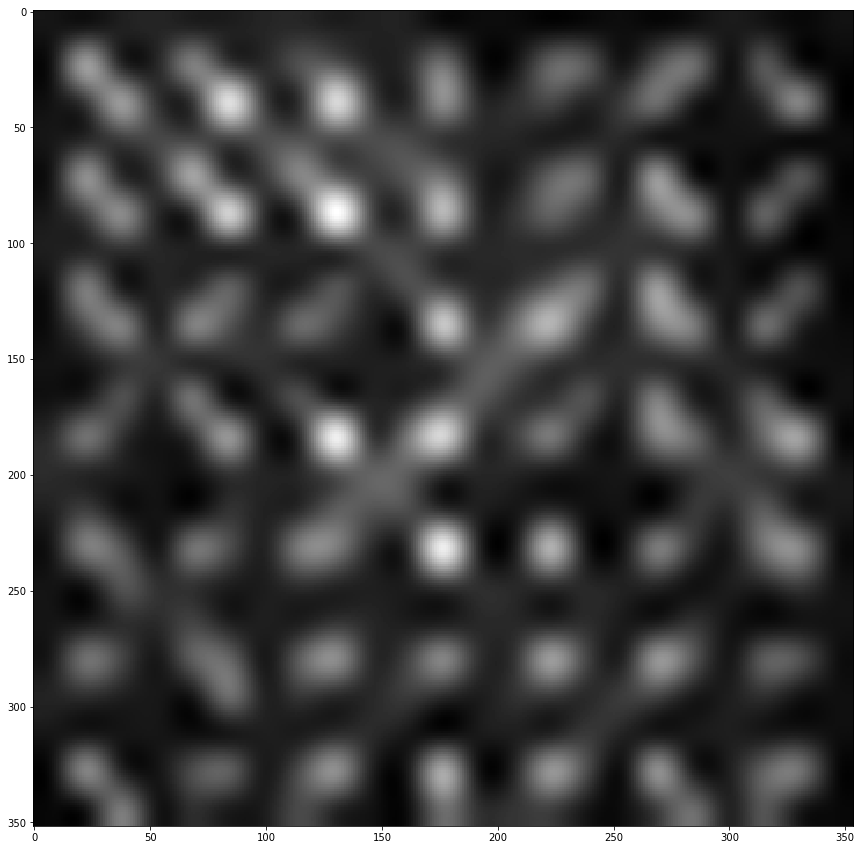

In [16]:
def norm01(mat):
    return cv2.normalize(mat, None, alpha=0., beta=1., norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

def calculateFeatureMaps(r, g, b, L, params):
    colorMaps = CFMcompute(r, g, b, L)
    orientationMaps = OFMcompute(L, params['gaborparams'] , params['thetas'])
    allFeatureMaps = {
        0: colorMaps[0],
        1: colorMaps[1],
        2: colorMaps[2],
        3: orientationMaps
    }
    return allFeatureMaps

def getPyramid(image, max_level):
    imagePyramid = {
        0: image
    } # scale zero = 1:1

    for i in range(1, max_level):
        imagePyramid[i] = cv2.pyrDown(imagePyramid[i-1])

    return imagePyramid

def run(image, params):
    b = image[:,:,0]/255.
    g = image[:,:,1]/255.
    r = image[:,:,2]/255.
    I = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)/255.

    b_pyr = getPyramid(b, params['max_level'])
    g_pyr = getPyramid(g, params['max_level'])
    r_pyr = getPyramid(r, params['max_level'])
    I_pyr = getPyramid(I, params['max_level'])

    # calculating scale-wise feature maps
    scaledFeaturePyramids = {}

    for i in range(2, len(b_pyr)):
        p_r = r_pyr[i]
        p_g = g_pyr[i]
        p_b = b_pyr[i]
        p_L = I_pyr[i]

        maps = calculateFeatureMaps(p_r, p_g, p_b, p_L, params)

        scaledFeaturePyramids[i] = maps


    # calculating center surround feature maps
    centerSurroundFeatureMaps = CSFcompute(scaledFeaturePyramids)


    # normalizing activation maps
    normalised_maps =[]
    norm_maps = centerSurroundFeatureMaps.copy()
    for i in range(0,4):
        for mat in norm_maps[i]:
            # Resizing to sigma = 4 maps
            nmap = processNormalization(mat)
            nmap = cv2.resize(nmap, (b_pyr[4].shape[1], b_pyr[4].shape[0]), interpolation=cv2.INTER_CUBIC)
            normalised_maps.append(nmap)


    # combine normalised maps
    comb_maps = []
    cfn = len(norm_maps[0])+len(norm_maps[1])
    ifn = len(norm_maps[2])
    ofn = len(norm_maps[3])

    comb_maps.append(normalised_maps[0])
    for i in range(1, cfn):
        comb_maps[0] = np.add(comb_maps[0], normalised_maps[i])

    comb_maps.append(normalised_maps[cfn])
    for i in range(cfn+1, cfn + ifn):
        comb_maps[1] = np.add(comb_maps[1], normalised_maps[i])

    comb_maps.append(normalised_maps[cfn + ifn])
    for i in range(cfn + ifn + 1, cfn + ifn + ofn):
        comb_maps[2] = np.add(comb_maps[2], normalised_maps[i])


    # normalise top channle maps
    ntcmaps = [None]*3
    for i in range(0,3):
        ntcmaps[i] = processNormalization(comb_maps[i])

    # add all of them
    mastermap = (ntcmaps[0] + ntcmaps[1] + ntcmaps[2])/3.0

    #post processing
    gray = norm01(mastermap)
    # blurred = cv2.GaussianBlur(gray,(3,3), 4)
    # gray = norm01(blurred)
    mastermap_res = cv2.resize(gray, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC)

    return mastermap_res

def setupParams():
    #'stddev': 2,
    #'elongation': 2,
    #'filterSize': -1,
    gaborparams = {
        'stddev': 4,
        'elongation': 1.0,
        'filterSize': -1,
        'filterPeriod': np.pi
    }
    
    #'sigma_frac_act': 0.15, 
    #'sigma_frac_norm': 0.06,
    params = {
        'gaborparams': gaborparams,
        'sigma_frac_act': 0.16, 
        'sigma_frac_norm': 0.08,
        'max_level': 9,
        'thetas': [0, 45, 90, 135]
    }

    return params


if __name__ == '__main__':
    #https://github.com/shreelock/gbvs/blob/master/ittikochneibur.py 
    params = setupParams()
   
    img = cv2.imread("./testimages/test3.png", 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

    saliency_map = run(img, params)*255.0
 
    plt.rcParams["figure.figsize"] = (15,15)
    plt.imshow(saliency_map, cmap='gray')

In [ ]:
def calc_score(self, actual, salmap, stepSize=.01, Nrand=100000):
        """
            Computer AUC score.
            :param actual : ground-truth annotations
            :param salmap : predicted saliency map
            :return score: int : score
        """

        salMap = salmap - np.min(salmap)
        if np.max(salMap) > 0:
            salMap = salMap / np.max(salMap)

        S = salMap.reshape(-1)
        Sth = np.asarray([ salMap[y-1][x-1] for y,x in actual ])

        Nfixations = len(actual)
        Npixels = len(S)

        # sal map values at random locations
        randfix = S[np.random.randint(Npixels, size=Nrand)]

        allthreshes = np.arange(0,np.max(np.concatenate((Sth, randfix), axis=0)),stepSize)
        allthreshes = allthreshes[::-1]
        tp = np.zeros(len(allthreshes)+2)
        fp = np.zeros(len(allthreshes)+2)
        tp[-1]=1.0
        fp[-1]=1.0
        tp[1:-1]=[float(np.sum(Sth >= thresh))/Nfixations for thresh in allthreshes]
        fp[1:-1]=[float(np.sum(randfix >= thresh))/Nrand for thresh in allthreshes]

        auc = np.trapz(tp,fp)
        return auc

def compute_score(self, gts, res):
        """
        Computes AUC score for a given set of predictions and fixations
        :param gts : dict : fixation points with "image name" key and list of points as values
        :param res : dict : salmap predictions with "image name" key and ndarray as values
        :returns: average_score: float (mean NSS score computed by averaging scores for all the images)
        """
        assert(gts.keys() == res.keys())
        imgIds = res.keys()
        score = []
        for id in imgIds:
            img = self.imgs[id]
            fixations  = gts[id]
            height,width = (img['height'],img['width'])
            salMap = self.saliconRes.decodeImage(res[id])
            mapheight,mapwidth = np.shape(salMap)
            salMap = scipy.ndimage.zoom(salMap, (float(height)/mapheight, float(width)/mapwidth), order=3)
            score.append(self.calc_score(fixations,salMap))
        average_score = np.mean(np.array(score))
        return average_score, np.array(score)
